这个例子显示了从一组平行的投影中重建图像，这些投影是沿着不同的角度获得的。这样的数据集是在computed tomography (CT)。

如果没有关于样本的任何先验信息，重建图像所需的投影数是图像线性大小l的数量级(以像素为单位)。为了简单起见，我们在这里考虑稀疏图像，其中只有对象边界上的像素有一个非零值。例如，这些数据可以与蜂窝式的布局相对应。但是，请注意，大多数图像都是在不同的基础上稀疏的，例如Haar wavelets。只获得1/7的投影，因此有必要使用样本上现有的先验信息(其稀疏性)：这是压缩感知的一个例子。

层析投影运算是一种线性变换。除了对应于线性回归的数据保真度外，我们还惩罚了图像的L1范数，以说明其稀疏性。由此产生的优化问题称为Lasso。我们使用 sklearn.linear_model.Lasso类，它使用坐标下降算法。重要的是，此实现在稀疏矩阵上的计算效率比此处用投影运算更有效。

用l1惩罚进行重建得到了零误差的结果(所有像素都被成功地标记为0或1)，即使在投影中添加了噪声也是如此。相比之下，L2惩罚(sklearn.linear_model.Ridge)会产生大量的像素标记错误。在重建图像上观察到重要的伪影，与L1惩罚相反。特别要注意的是，圆形伪影将角上的像素分隔开来，这使得投影比中央的盘少。

In [23]:
print(__doc__)

# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause

import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
# 添加以下代码设置中文字体
plt.rcParams["font.family"] = ["SimHei"]  # 支持中文的字体列表
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

Automatically created module for IPython interactive environment


In [24]:
# 辅助函数：计算点在投影方向上的权重
def _weights(x, dx=1, orig=0):
    """
    计算每个点在离散化网格中的权重
    返回网格索引和对应的权重值
    """
    x = np.ravel(x)  # 将输入展平为一维数组
    floor_x = np.floor((x - orig) / dx).astype(np.int64)  # 计算网格索引
    alpha = (x - orig - floor_x * dx) / dx  # 计算插值权重
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))

In [25]:
# 辅助函数：生成图像中心坐标
def _generate_center_coordinates(l_x):
    """生成图像中每个像素的中心坐标"""
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)  # 创建网格坐标
    center = l_x / 2.  # 计算中心位置
    X += 0.5 - center  # 调整坐标原点到图像中心
    Y += 0.5 - center
    return X, Y

In [26]:
# 核心函数：构建断层扫描投影矩阵
def build_projection_operator(l_x, n_dir):
    """ 计算断层扫描设计矩阵（投影矩阵）

    Parameters
    ----------
    l_x : int
        图像数组的线性尺寸
    n_dir : int
        采集投影的角度数量

    Returns
    -------
    p : sparse matrix of shape (n_dir*l_x, l_x**2)
        投影矩阵，将图像映射到投影空间
    """
    X, Y = _generate_center_coordinates(l_x)  # 生成中心坐标
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)  # 生成均匀分布的投影角度
    data_inds, weights, camera_inds = [], [], []  # 初始化索引和权重列表
    data_unravel_indices = np.arange(l_x ** 2)  # 图像像素的一维索引
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    
    # 对每个投影角度计算投影
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y  # 旋转坐标系
        inds, w = _weights(Xrot, dx=1, orig=X.min())  # 计算权重和索引
        mask = np.logical_and(inds >= 0, inds < l_x)  # 过滤有效索引
        
        # 收集数据
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)  # 添加角度偏移
        data_inds += list(data_unravel_indices[mask])
    
    # 创建稀疏矩阵
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator

In [27]:
# 生成合成测试数据
def generate_synthetic_data():
    """ 生成合成二值测试图像 """
    rs = np.random.RandomState(0)  # 设置随机种子确保结果可重复
    n_pts = 36  # 随机点数量
    x, y = np.ogrid[0:l, 0:l]  # 创建坐标网格
    
    # 创建圆形掩码（限制在图像中心区域）
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    
    # 在随机位置放置点并应用高斯滤波
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)  # 生成随机点
    mask[(points[0]).astype(np.int64), (points[1]).astype(np.int64)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)  # 平滑处理
    
    # 生成最终的二值图像
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))  # 创建边缘特征

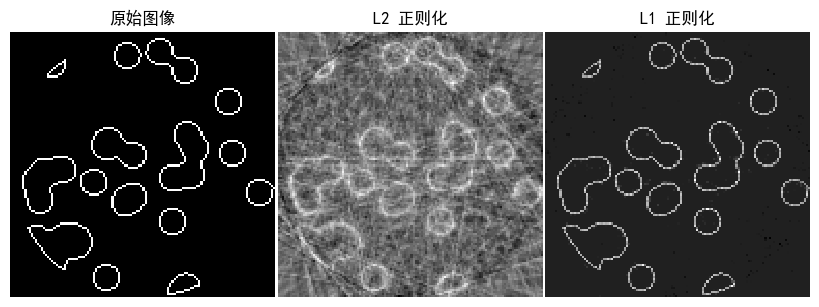

In [28]:
# 主程序：生成数据并进行重建
if __name__ == "__main__":
    # 设置参数并生成数据
    l = 128  # 图像尺寸
    proj_operator = build_projection_operator(l, l // 7)  # 构建投影矩阵
    data = generate_synthetic_data()  # 生成合成图像
    
    # 生成带噪声的投影数据
    proj = proj_operator * data.ravel()[:, np.newaxis]  # 计算投影
    proj += 0.15 * np.random.randn(*proj.shape)  # 添加高斯噪声
    
    # 使用L2正则化(Ridge)进行图像重建
    rgr_ridge = Ridge(alpha=0.2)  # 创建Ridge回归模型
    rgr_ridge.fit(proj_operator, proj.ravel())  # 拟合模型
    rec_l2 = rgr_ridge.coef_.reshape(l, l)  # 重塑为图像形状
    
    # 使用L1正则化(Lasso)进行图像重建
    # 最佳alpha值通过交叉验证确定
    rgr_lasso = Lasso(alpha=0.001)  # 创建Lasso模型
    rgr_lasso.fit(proj_operator, proj.ravel())  # 拟合模型
    rec_l1 = rgr_lasso.coef_.reshape(l, l)  # 重塑为图像形状
    
    # 可视化结果
    plt.figure(figsize=(8, 3.3))
    
    # 显示原始图像
    plt.subplot(131)
    plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    plt.title('原始图像')
    
    # 显示L2重建结果
    plt.subplot(132)
    plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
    plt.title('L2 正则化')
    plt.axis('off')
    
    # 显示L1重建结果
    plt.subplot(133)
    plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
    plt.title('L1 正则化')
    plt.axis('off')
    
    # 调整子图布局
    plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
    plt.show()